In [1]:
#import libraries
import pandas as pd
import numpy as np
import operator
from csv import reader
from math import sqrt
import matplotlib.pyplot as plt
#Upsampling
data=pd.read_csv('C:\\Users\\HP\\Desktop\\ML\\catalog3\\cat3.csv')
df_majority=data[data['class']==1]
df_minority = data[data['class']==0]
df_minority_random=df_minority.sample(n=len(df_majority),replace=True)
df_upsampled=pd.concat([df_majority,df_minority_random],axis=0)

#splitting into y and x
y=df_upsampled['class']
#converting into np.array
y=y.values
#dropping some of the variables
x=df_upsampled.drop('class',axis=1)
x=x.drop('galex_objid',axis=1)
x=x.drop('sdss_objid',axis=1)
x=x.drop('spectrometric_redshift',axis=1)
x=x.drop('pred',axis=1)
x=x.drop('Unnamed: 0',axis=1)
#converting into np.array
x=x.values

In [2]:

def split_into_train_test(x, y):
    A = np.random.rand(x.shape[0])
    s = A < np.percentile(A, 70)
    #print(split)
    X_test =  x[~s]
    y_test = y[~s]
    X_train = x[s]
    y_train = y[s]
    #print(len(X_train), len(y_train), len(X_test), len(y_test))
    return X_train, y_train, X_test, y_test

#Splitting into train and test data sets
X_train, y_train, X_test, y_test = split_into_train_test(x,y) 

#Next we need to transform all the attributes to have 0 mean and standard deviation 1.This is essential because the larger 
#ranged attributes should not affect/contribute to the result more that the others.
#i.e in the below functions we are imitating what the standard scalar function does.

#Function to calculate the mean of each of the columns
def mean(df):
    means_of_cols = [0 for i in range(len(df[0]))]
    for i in range(len(df[0])):
        column = [row[i] for row in df]
        means_of_cols[i] = sum(column) / float(len(df))
    return means_of_cols

#Function to calculate the standard deviations of each of the columns
def standard_deviation(df, means_of_cols):
    std_of_cols = [0 for i in range(len(df[0]))]
    for i in range(len(df[0])):
        variance = [pow(x[i]-means_of_cols[i], 2) for x in df]
        std_of_cols[i] = sum(variance)
    std_of_cols = [sqrt(x/(float(len(df)-1))) for x in std_of_cols]
    return std_of_cols

# standardize
def standardize(df, means_of_cols, std_of_cols):
    for row in df:
        for i in range(len(row)):
            row[i] = (row[i] - means_of_cols[i]) / std_of_cols[i]


means_of_cols = mean(X_train)
std_of_cols = standard_deviation(X_train, means_of_cols)


standardize(X_train, means_of_cols, std_of_cols)
standardize(X_test, means_of_cols, std_of_cols)


In [4]:

# function to calculate euclidean distance
def distance(x1, x2, n):
    d = 0
    for x in range(n):
        d += np.square(x1[x] - x2[x])
    return np.sqrt(d)

# KNN model
def knn(train, test_row, k):
    dist = {}
    n = test_row.shape[0]
    for x in range(len(train)):
        d = distance(test_row, train[x], n)
        dist[x] = d
    #Ordered_dist contains the row numbers of the rows of the training data set ordered in the ascending order of 
    #the distance to the test instance
    ordered_dist = sorted(dist.items(), key=operator.itemgetter(1))
    neighbors = []
    for i in range(k):
        neighbors.append(ordered_dist[i][0])
    #Neighbors contains only the first K elements of the Ordered_dist
    counts = {}  
    for i in range(len(neighbors)):
        target = y_train[neighbors[i]]
        if target in counts:
            counts[target] += 1
        else:
            counts[target] = 1
    #Counts is a dictionary that keeps track of how many votes each of the outputs have recieved 
    ordered_count = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
    #Ordered count sorts this dictionary based on the number of votes and the function returns the target class with the maximum
    #number of votes
    return (ordered_count[0][0]) 

#Applying the model on the test data and storing the output in a list called predictions
predictions=[]
for i in range(len(X_test)):
    predictions.append(knn(X_train,X_test[i],3))


In [5]:
def accuracy(y_test, predictions):
    correct = 0
    for x in range(len(y_test)):
        if y_test[x] == predictions[x]:
            correct += 1
    return (correct/float(len(y_test))) * 100.0

print("accuracy for catalog 3")
print(accuracy(y_test,predictions))


accuracy for catalog 3
97.6470588235294


In [6]:
def confusionmatrix(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    l0=0
    l1=0
    for i in range(len(y_pred)):
        if(y_actual[i]==0):
            l0+=1
        elif(y_actual[i]==1):
            l1+=1
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1
    return(TP, FP, TN, FN,l0,l1)

TP,FP,TN,FN,l0,l1=confusionmatrix(y_test,predictions)
print("True positives: ",TP)
print("False positives: ",FP)
print("True negatives: ",TN)
print("False negatives: ",FN)
print("class 1 accuracy:",((TP/l1)*100))
print("class 0 accuracy:",((TN/l0)*100))
recall=TP/(TP+FN)
precision=TP/(TP+FP)
false_pos_rate=FP/(FP+TN)
fscore=(2*recall*precision)/(recall+precision)
print("recall: ",recall,"\nprecision: ",precision,"\nFPR :",false_pos_rate,"\nFscore :",fscore)

True positives:  1084
False positives:  26
True negatives:  1157
False negatives:  28
class 1 accuracy: 97.48201438848922
class 0 accuracy: 97.8021978021978
recall:  0.9748201438848921 
precision:  0.9765765765765766 
FPR : 0.02197802197802198 
Fscore : 0.9756975697569759


In [12]:
#Catalog 1:
#Now we test the catalog 1 on the model built on catalog 3
data=pd.read_csv('C:\\Users\\HP\\Desktop\\ML\\catalog1\\cat1.csv')
df_majority=data[data['class']==1]
df_minority = data[data['class']==0]
df_minority_random=df_minority.sample(n=len(df_majority),replace=True)
df_upsampled=pd.concat([df_majority,df_minority_random],axis=0)

#splitting into y and x
y=df_upsampled['class']
#converting into np.array
y=y.values
#dropping some of the variables
x=df_upsampled.drop('class',axis=1)
x=x.drop('galex_objid',axis=1)
x=x.drop('sdss_objid',axis=1)
x=x.drop('spectrometric_redshift',axis=1)
x=x.drop('pred',axis=1)
x=x.drop('Unnamed: 0',axis=1)
#converting into np.array
x=x.values


standardize(x, means_of_cols, std_of_cols)
predictions=[]
for i in range(len(x)):
    predictions.append(knn(X_train,x[i],3))
print("accuracies for catalog 1")    
print(accuracy(y,predictions))
TP,FP,TN,FN=confusionmatrix(y,predictions)
print("True positives: ",TP)
print("False positives: ",FP)
print("True negatives: ",TN)
print("False negatives: ",FN)


recall=TP/(TP+FN)
precision=TP/(TP+FP)
false_pos_rate=FP/(FP+TN)
fscore=(2*recall*precision)/(recall+precision)
print("recall: ",recall,"\nprecision: ",precision,"\nFPR :",false_pos_rate,"\nFscore :",fscore)

accuracies for catalog 1
99.74789915966386
True positives:  592
False positives:  0
True negatives:  595
False negatives:  3
recall:  0.9949579831932773 
precision:  1.0 
FPR : 0.0 
Fscore : 0.9974726200505476


In [23]:
#Catalog 2:
#Now we test the catalog 2 on the model built on catalog 3
data=pd.read_csv('C:\\Users\\HP\\Desktop\\ML\\catalog2\\cat2.csv')
df_majority=data[data['class']==1]
df_minority = data[data['class']==0]
df_minority_random=df_minority.sample(n=len(df_majority),replace=True)
df_upsampled=pd.concat([df_majority,df_minority_random],axis=0)

#splitting into y and x
y=df_upsampled['class']
#converting into np.array
y=y.values
#dropping some of the variables
x=df_upsampled.drop('class',axis=1)
x=x.drop('galex_objid',axis=1)
x=x.drop('sdss_objid',axis=1)
x=x.drop('spectrometric_redshift',axis=1)
x=x.drop('pred',axis=1)
x=x.drop('Unnamed: 0',axis=1)
x=x.drop('Unnamed: 0.1',axis=1)
#converting into np.array
x=x.values


standardize(x, means_of_cols, std_of_cols)
predictions=[]
for i in range(len(x)):
    predictions.append(knn(X_train,x[i],3))
print("accuracies for catalog 2")
print(accuracy(y,predictions))
TP,FP,TN,FN=confusionmatrix(y,predictions)
print("True positives: ",TP)
print("False positives: ",FP)
print("True negatives: ",TN)
print("False negatives: ",FN)


recall=TP/(TP+FN)
precision=TP/(TP+FP)
false_pos_rate=FP/(FP+TN)
fscore=(2*recall*precision)/(recall+precision)
print("recall: ",recall,"\nprecision: ",precision,"\nFPR :",false_pos_rate,"\nFscore :",fscore)

accuracies for catalog 2
98.5908950139362
True positives:  3202
False positives:  64
True negatives:  3165
False negatives:  27
recall:  0.9916382781046764 
precision:  0.9804041641151255 
FPR : 0.019820377825952307 
Fscore : 0.9859892224788299


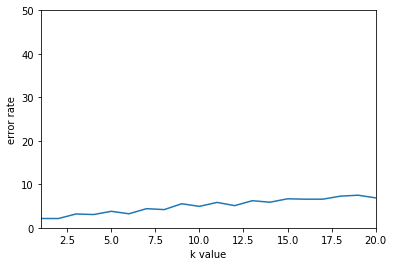

In [15]:
#Finding the right value for K
#accuracies were found by training and testing on catalog 3 with different K values
accuracies =[97.86492374727669,
97.86492374727669,
96.81917211328977,
96.94989106753813,
96.20915032679738,
96.7755991285403,
95.59912854030502,
95.81699346405229,
94.46623093681917,
95.07625272331155,
94.16122004357298,
94.90196078431372,
93.76906318082789,
94.11764705882352,
93.33333333333333,
93.42047930283225,
93.42047930283225,          
92.72331154684096,
92.50544662309368,
93.11546840958606]
error_rate=[]
for i in accuracies:
    #print(100-i)
    error_rate.append(100-i)
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14,15,16,17,18,19,20], error_rate)
plt.xlabel('k value')
plt.ylabel('error rate')
plt.xlim(1, 20)
plt.ylim(0, 50)
plt.show()